### 1. Importing and Loading Required Libraries

#### 1.1. Installing and Loading Required Packages
This section installs and loads the essential R packages for data analysis and visualization. The `ggcorrplot` package creates correlation plots, `car` offers regression diagnostics, and `HH` provides additional statistical methods. The `tidyverse` is used for data manipulation, `ggplot2` for visualization, and both `gridExtra` and `cowplot` help arrange multiple plots.

In [11]:
install.packages("showtext")
install.packages("ggcorrplot")
install.packages("car")
install.packages("HH")
install.packages("lmtest")
install.packages("nortest")
# Load necessary libraries
library(showtext)
#library(tidyverse)
#library(ggplot2)
#library(gridExtra)
#library(cowplot)
library(ggcorrplot)
library(car)
library(HH)
library(lmtest)
library(nortest)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### 2. Data Preparation and Transformation

#### 2.1. Reading the Data
Reading the data from the CSV file and displaying the first few rows to understand the structure of the data.

In [12]:
data_rent <- read.csv("/Users/karimmbk/Documents/halef-thesis/regression/resources/rent_2018_2021.csv", dec = ".", header = TRUE, sep = ";")

#### 2.2. Convert categorical variables to factors (dummy variables)
Converting categorical variables to factors to use them in the regression model.

In [13]:
data_rent$gym <- as.factor(data_rent$gym)
data_rent$field_quadra <- as.factor(data_rent$field_quadra)
data_rent$elevator <- as.factor(data_rent$elevator)
data_rent$furnished <- as.factor(data_rent$furnished)
data_rent$swimming_pool <- as.factor(data_rent$swimming_pool)

#### 2.3. Convert date to date format
Converting the date column to a date format to filter the data by year.

In [14]:
data_rent$date <- as.Date(data_rent$date, format = "%d/%m/%Y")

### 3. Model Specification and Fitting
 Analyzing the correlation between the variables to understand the relationship between them.

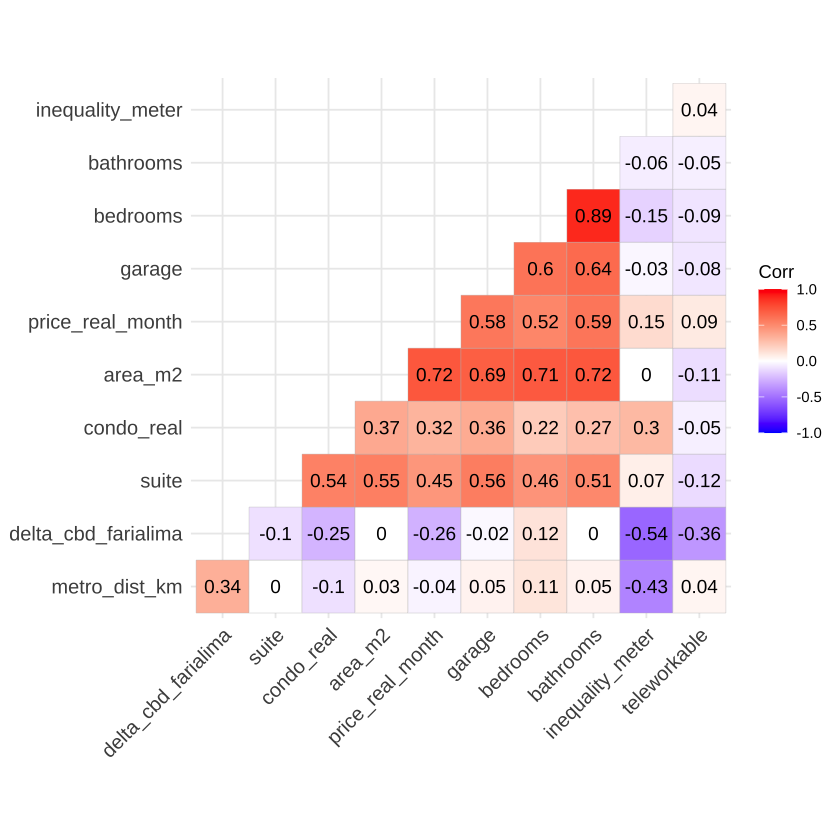

In [15]:
corr_data <- data_rent[, (names(data_rent) %in% c("price_real_month", "area_m2", "bedrooms", "bathrooms", "garage", "condo_real", "metro_dist_km", "delta_cbd_farialima", "teleworkable", "inequality_meter", "suite"))]

# Compute correlation at 2 decimal places
corr_matrix <- round(cor(corr_data), 2)
ggcorrplot(corr_matrix, hc.order = TRUE, type = "lower", lab = TRUE)

#### 3.1. Defining the Model parameters
This subsection defines the formula for the regression model, specifying `price_m2` as the dependent variable and various property features as independent variables.

In [16]:
price_m2_log <- log(data_rent$price_m2)
params <- (price_m2_log ~ area_m2 +
  bedrooms +
  metro_dist_km +
  delta_cbd_farialima +
  condo_real +
  inequality_meter +
  teleworkable +
  garage +
  gym +
  field_quadra +
  elevator +
  furnished +
  swimming_pool)

#data_rent_2018 <- filter(data_rent, year(date) == 2018)
reg <- lm(params, data = data_rent)

#### 3.2 Checking the results for the linear regression model
Checking the results for the linear regression model to understand the relationship between the variables.

In [17]:
summary(reg)


Call:
lm(formula = params, data = data_rent)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.49123 -0.24469 -0.01951  0.22947  1.44548 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          3.733e+00  4.256e-02  87.708  < 2e-16 ***
area_m2             -3.352e-03  1.755e-04 -19.094  < 2e-16 ***
bedrooms            -1.447e-01  8.034e-03 -18.012  < 2e-16 ***
metro_dist_km       -2.628e-02  3.483e-03  -7.545 5.04e-14 ***
delta_cbd_farialima -4.096e-02  1.557e-03 -26.299  < 2e-16 ***
condo_real          -5.014e-05  7.828e-06  -6.405 1.60e-10 ***
inequality_meter     7.346e-03  5.627e-04  13.055  < 2e-16 ***
teleworkable         4.716e-01  4.781e-02   9.864  < 2e-16 ***
garage               1.990e-01  8.108e-03  24.545  < 2e-16 ***
gym1                 1.230e-01  2.456e-02   5.009 5.60e-07 ***
field_quadra1        1.145e-02  2.066e-02   0.554  0.57959    
elevator1           -5.370e-02  1.686e-02  -3.184  0.00146 ** 
furnished1      

#### 3.1.1 Running the diagnostic tests
Running the diagnostic tests to check the normality, heteroskedasticity, and autocorrelation of the residuals

In [18]:
# Perform Shapiro-Wilk test
residuals_best_model <- resid(reg)
sample_size <- length(residuals_best_model)

if (sample_size >= 3 && sample_size <= 5000) {
  shapiro_test <- shapiro.test(residuals_best_model)
  print(shapiro_test)
  if (shapiro_test$p.value > 0.01) {
    print("Pass: Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Residuals are not normally distributed (reject H0).")
  }
} else {
  print("Sample size out of range for Shapiro-Wilk test, using Anderson-Darling test instead.")
  ad_test <- ad.test(residuals_best_model)
  print(ad_test)
  if (ad_test$p.value > 0.01) {
    print("Pass: Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Residuals are not normally distributed (reject H0).")
  }
}

# Perform Breusch-Pagan test
bp_test <- bptest(reg)
print(bp_test)
if (bp_test$p.value < 0.01) {
  print("Heteroskedasticity detected (reject H0).")
} else {
  print("Pass: No heteroskedasticity detected (fail to reject H0).")
}

# Perform Durbin-Watson test
dw_test <- dwtest(reg)
print(dw_test)
dw_stat <- dw_test$statistic
if (dw_stat < 1.5) {
  print("Positive autocorrelation detected.")
} else if (dw_stat > 2.5) {
  print("Negative autocorrelation detected.")
} else {
  print("Pass: No autocorrelation detected.")
}

[1] "Sample size out of range for Shapiro-Wilk test, using Anderson-Darling test instead."

	Anderson-Darling normality test

data:  residuals_best_model
A = 11.071, p-value < 2.2e-16

[1] "Residuals are not normally distributed (reject H0)."

	studentized Breusch-Pagan test

data:  reg
BP = 108.93, df = 13, p-value < 2.2e-16

[1] "Heteroskedasticity detected (reject H0)."

	Durbin-Watson test

data:  reg
DW = 0.83507, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0

[1] "Positive autocorrelation detected."


#### 3.3 Plotting the residuals
Plotting the standardized residuals and the histogram with the normal curve.

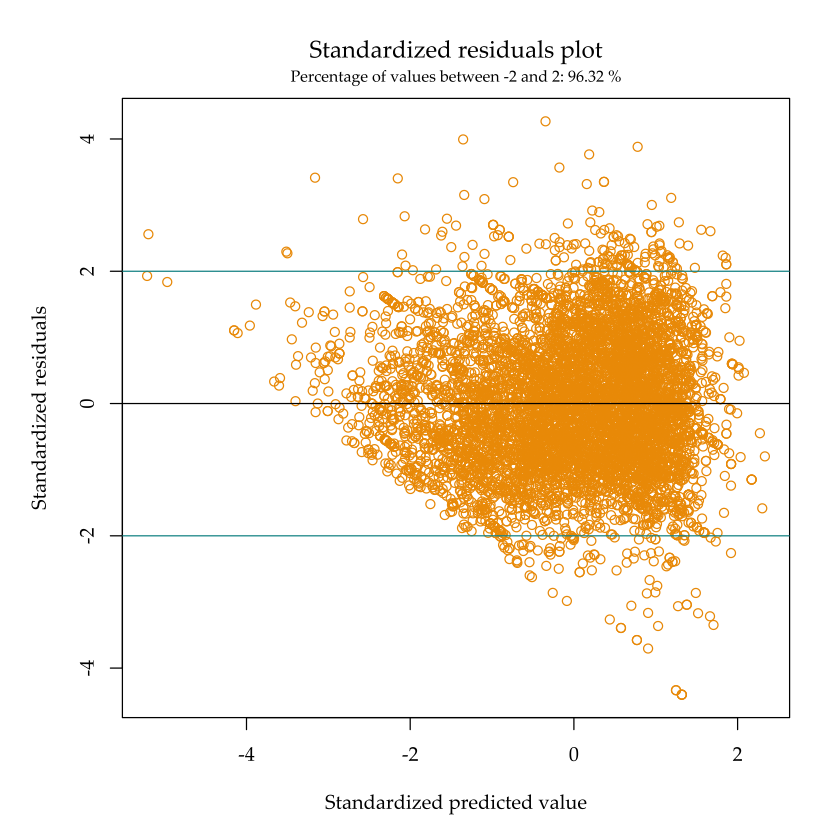

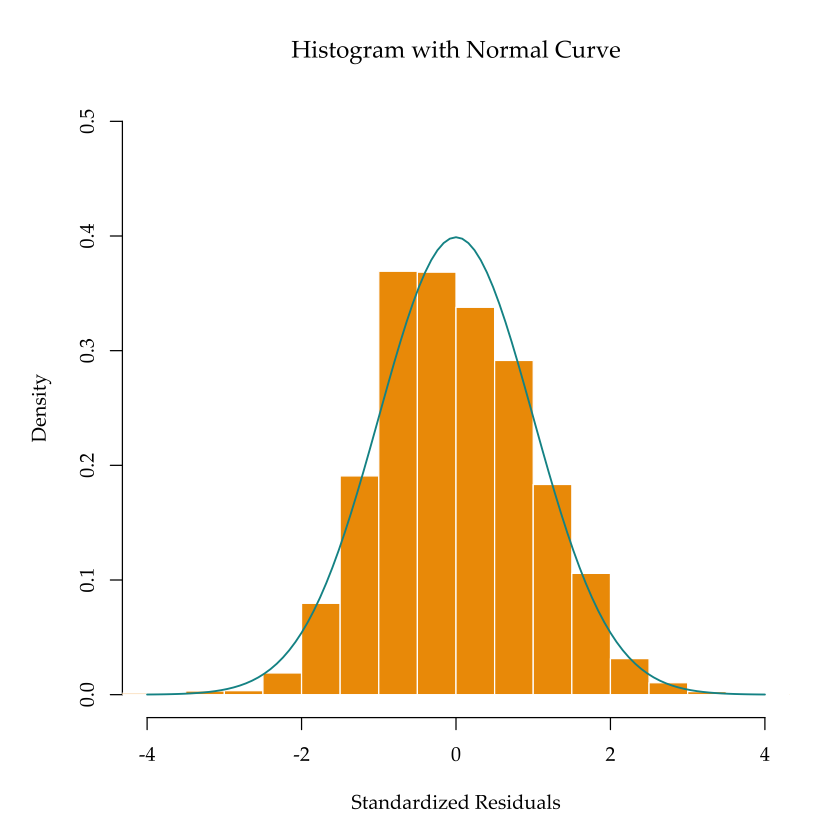

In [19]:
# Adicionar a fonte Palatino Linotype usando o caminho completo para o arquivo TTF
# Substitua "path/to/PalatinoLinotype.ttf" pelo caminho real do arquivo TTF
font_add("Palatino", regular = "/Users/karimmbk/Documents/halef-thesis/regression/resources/Palatino Linotype.ttf")

# Habilitar showtext
showtext_auto()

predicted <- predict(reg)
residuals <- resid(reg)
stand_predicted <- (predicted - mean(predicted)) / sd(predicted)
stand_residuals <- (residuals - mean(residuals)) / sd(residuals)

# Ajustar a fonte e o tamanho do texto
par(family = "Palatino", cex = 1, mar = c(5, 5, 4, 2) + 0.1)  # Ajustar as margens

# Plotar os resíduos padronizados
plot(stand_predicted, stand_residuals, main = "Standardized residuals plot",
     xlab = "Standardized predicted value", ylab = "Standardized residuals",
     col = "#EE9B00", pch = 1)  # Ajustar a cor dos pontos e o estilo

# Adicionar linhas de referência
abline(0, 0, col = "black")
abline(h = -2, col = "#0A9396")
abline(h = 2, col = "#0A9396")

# Calculate the total number of values within the interval [-2, 2]
within_interval <- sum(stand_residuals >= -2 & stand_residuals <= 2)
mtext(paste("Percentage of values between -2 and 2:", round(within_interval / length(stand_residuals) * 100, 2), "%"), side = 3, line = 0.5, cex = 0.8)

# Calculate the histogram data without plotting
hist_data <- hist(stand_residuals, plot = FALSE)

# Calculate the normal distribution density values
x_values <- seq(min(stand_residuals), max(stand_residuals), length = 100)
y_values <- dnorm(x_values, mean = mean(stand_residuals), sd = sd(stand_residuals))

# Determine the y-axis limit
#y_max <- max(c(hist_data$density, y_values))

# Plotar o histograma com limite no eixo y, e ajustar a cor
hist(stand_residuals, freq = FALSE, ylim = c(0, 0.5), xlim = c(-4, 4),
     main = "Histogram with Normal Curve", xlab = "Standardized Residuals",
     col = "#EE9B00", border = "#FFFFFF")  # Ajuste a cor do histograma e da borda

# Adicionar a curva de distribuição normal ajustando a cor
curve(dnorm(x, mean = mean(stand_residuals), sd = sd(stand_residuals)), add = TRUE, lwd = 1.5, col = "#0A9396")  # Ajuste a cor da curva

### 4. Finding the best model
Creating a code to run the best model and generate the best combination of variables and transformations to generate the final regression model.

#### 4.1 Function to calculate the best model (highest R²)
The function `calculate_best_model` calculates the best model by generating all possible combinations of transformations for the independent variables. The function returns the best model, the best combination of variables and transformations, and the best R² value.

In [35]:
calculate_best_model <- function(data, dependent_var, independent_vars, transformations) {
  best_r2 <- -Inf
  best_model <- NULL
  best_combination <- NULL
  list_r2 <- NULL

  # Gerar todas as combinações de transformações para todas as variáveis independentes
  trans_combinations <- expand.grid(rep(list(transformations), length(independent_vars)))
  colnames(trans_combinations) <- independent_vars

  for (trans_row in seq_len(nrow(trans_combinations))) {
    transformed_data <- data
    formula_parts <- c(dependent_var, "~")
    for (var in independent_vars) {
      trans <- trans_combinations[trans_row, var]
      transformed_var <- switch(as.character(trans),
                                "X" = data[[var]],
                                "1_X" = 1 / data[[var]],
                                "LnX" = log(data[[var]]),
                                "X__2" = data[[var]]^2,
                                "X__1_2" = sqrt(data[[var]]),
                                "1_X__2" = 1 / (data[[var]]^2),
                                "1_X__1_2" = 1 / sqrt(data[[var]]))
      trans_name <- paste(var, trans, sep = "_")
      transformed_data[[trans_name]] <- transformed_var
      formula_parts <- c(formula_parts, trans_name)
    }

    formula_string <- paste(paste(formula_parts, collapse = " + "), " + garage + gym + field_quadra + elevator + furnished + swimming_pool")
    formula_string <- gsub(" \\+ ~ \\+ ", " ~ ", formula_string)  # Corrigir formatação da fórmula
    formula <- as.formula(formula_string)
    model <- lm(formula, data = transformed_data)

    r2 <- summary(model)$r.squared
    list_r2 <- append(list_r2, r2)

    # Verificar os testes de diagnóstico
    # ad_test <- ad.test(residuals(model))
    # bp_test <- bptest(model)
    # dw_test <- dwtest(model)

    # Se os testes passarem, considerar o modelo
    if (r2 > best_r2) {
      best_r2 <- r2
      best_model <- model
      best_combination <- list(variables = independent_vars, transformations = as.list(trans_combinations[trans_row,]))
    }
  }
  return(list(best_model = best_model, best_combination = best_combination, best_r2 = best_r2, list_r2 = list_r2))
}

##### 4.1.1 Defining the variables to be used in the model
Defining the dependent and independent variables and transformations to be used in the model.

In [36]:
data_rent$price_real_month <- log(data_rent$price_real_month)
dependent_var <- "price_real_month"
independent_vars <- c("area_m2", "bedrooms", "metro_dist_km", "delta_cbd_farialima", "inequality_meter", "teleworkable")
transformations <- c("X", "1_X", "LnX", "X__2", "X__1_2", "1_X__2", "1_X__1_2")

##### 4.1.2 Calculating the function to generate the best model
Running the function to generate the best model and print the results.

In [37]:
results_1 <- calculate_best_model(data_rent, dependent_var, independent_vars, transformations)

##### 4.1.3 Printing the result
Printing the best model, the best combination of variables and transformations, and the best R² value.

In [38]:
summary(results_1$best_model)


Call:
lm(formula = formula, data = transformed_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.097333 -0.014395 -0.000734  0.014999  0.071950 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 0.6060968  0.0031492 192.461  < 2e-16 ***
area_m2_LnX                 0.0405715  0.0007865  51.586  < 2e-16 ***
bedrooms_X__2              -0.0014571  0.0001191 -12.237  < 2e-16 ***
metro_dist_km_X__1_2       -0.0078386  0.0005710 -13.727  < 2e-16 ***
delta_cbd_farialima_X__1_2 -0.0135666  0.0004283 -31.677  < 2e-16 ***
inequality_meter_1_X       -1.0071537  0.0916544 -10.989  < 2e-16 ***
teleworkable_1_X           -0.0011216  0.0001167  -9.608  < 2e-16 ***
garage                      0.0129984  0.0004951  26.253  < 2e-16 ***
gym1                        0.0074014  0.0015035   4.923 8.72e-07 ***
field_quadra1               0.0006300  0.0012626   0.499  0.61782    
elevator1                  -0.0028697  0.001025

#### 4.2 Running the diagnostic tests
Running the diagnostic tests to check the normality, heteroskedasticity, and autocorrelation of the residuals.

In [39]:
# Perform Shapiro-Wilk test
residuals_best_model <- resid(results_1$best_model)
sample_size <- length(residuals_best_model)

if (sample_size >= 3 && sample_size <= 5000) {
  shapiro_test <- shapiro.test(residuals_best_model)
  print(shapiro_test)
  if (shapiro_test$p.value > 0.01) {
    print("Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Residuals are not normally distributed (reject H0).")
  }
} else {
  print("Sample size out of range for Shapiro-Wilk test, using Anderson-Darling test instead.")
  ad_test <- ad.test(residuals_best_model)
  print(ad_test)
  if (ad_test$p.value > 0.01) {
    print("Residuals are normally distributed (fail to reject H0).")
  } else {
    print("Residuals are not normally distributed (reject H0).")
  }
}

# Perform Breusch-Pagan test
bp_test <- bptest(results_1$best_model)
print(bp_test)
if (bp_test$p.value < 0.01) {
  print("Heteroskedasticity detected (reject H0).")
} else {
  print("No heteroskedasticity detected (fail to reject H0).")
}

# Perform Durbin-Watson test
dw_test <- dwtest(results_1$best_model)
print(dw_test)
dw_stat <- dw_test$statistic
if (dw_stat < 1.5) {
  print("Positive autocorrelation detected.")
} else if (dw_stat > 2.5) {
  print("Negative autocorrelation detected.")
} else {
  print("No autocorrelation detected.")
}


[1] "Sample size out of range for Shapiro-Wilk test, using Anderson-Darling test instead."

	Anderson-Darling normality test

data:  residuals_best_model
A = 7.5565, p-value < 2.2e-16

[1] "Residuals are not normally distributed (reject H0)."

	studentized Breusch-Pagan test

data:  results_1$best_model
BP = 198.77, df = 12, p-value < 2.2e-16

[1] "Heteroskedasticity detected (reject H0)."

	Durbin-Watson test

data:  results_1$best_model
DW = 0.78731, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0

[1] "Positive autocorrelation detected."


#### 4.3 Plotting the residuals
Plotting the standardized residuals and the histogram with the normal curve.

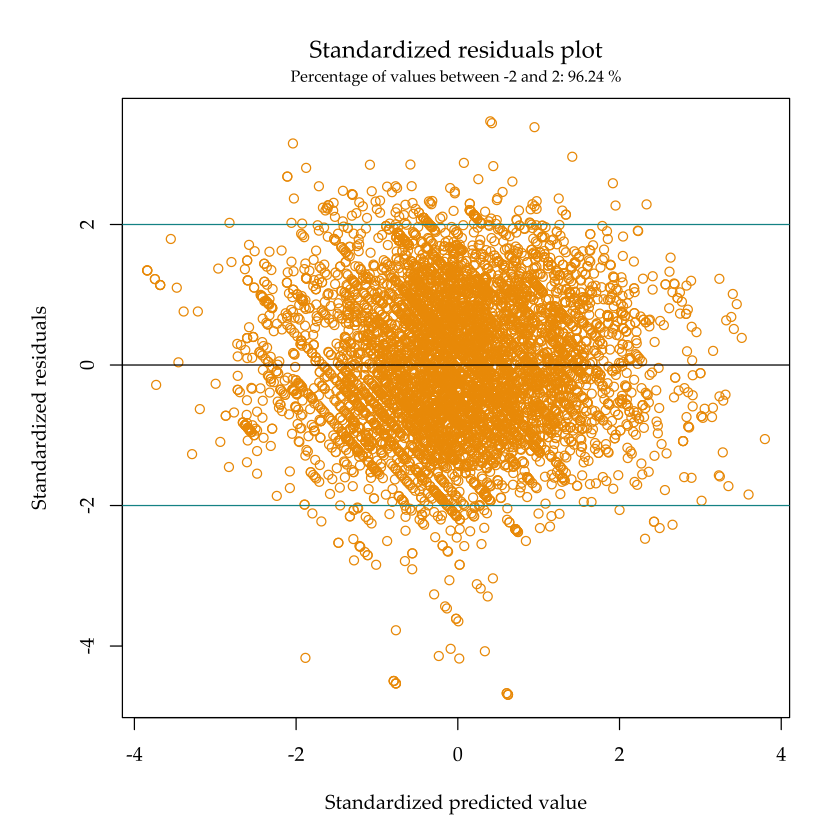

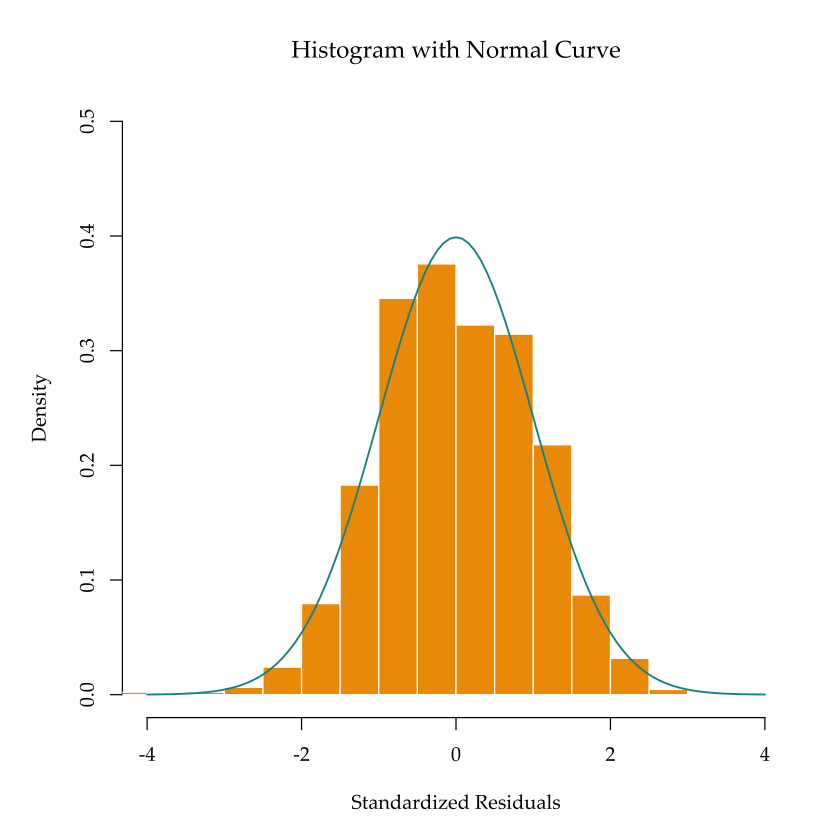

In [40]:
# Adicionar a fonte Palatino Linotype usando o caminho completo para o arquivo TTF
# Substitua "path/to/PalatinoLinotype.ttf" pelo caminho real do arquivo TTF
font_add("Palatino", regular = "/Users/karimmbk/Documents/halef-thesis/regression/resources/Palatino Linotype.ttf")

# Habilitar showtext
showtext_auto()

predicted<- predict(results_1$best_model)
residuals <- resid(results_1$best_model)
stand_predicted <- (predicted - mean(predicted)) / sd(predicted)
stand_residuals <- (residuals - mean(residuals)) / sd(residuals)

# Ajustar a fonte e o tamanho do texto
par(family = "Palatino", cex = 1, mar = c(5, 5, 4, 2) + 0.1)  # Ajustar as margens

# Plotar os resíduos padronizados
plot(stand_predicted, stand_residuals, main = "Standardized residuals plot",
     xlab = "Standardized predicted value", ylab = "Standardized residuals",
     col = "#EE9B00", pch = 1)  # Ajustar a cor dos pontos e o estilo

# Adicionar linhas de referência
abline(0, 0, col = "black")
abline(h = -2, col = "#0A9396")
abline(h = 2, col = "#0A9396")

# Calculate the total number of values within the interval [-2, 2]
within_interval <- sum(stand_residuals >= -2 & stand_residuals <= 2)
mtext(paste("Percentage of values between -2 and 2:", round(within_interval / length(stand_residuals) * 100, 2), "%"), side = 3, line = 0.5, cex = 0.8)

# Calculate the histogram data without plotting
hist_data <- hist(stand_residuals, plot = FALSE)

# Calculate the normal distribution density values
x_values <- seq(min(stand_residuals), max(stand_residuals), length = 100)
y_values <- dnorm(x_values, mean = mean(stand_residuals), sd = sd(stand_residuals))

# Determine the y-axis limit
#y_max <- max(c(hist_data$density, y_values))

# Plotar o histograma com limite no eixo y, e ajustar a cor
hist(stand_residuals, freq = FALSE, ylim = c(0, 0.5), xlim = c(-4, 4),
     main = "Histogram with Normal Curve", xlab = "Standardized Residuals",
     col = "#EE9B00", border = "#FFFFFF")  # Ajuste a cor do histograma e da borda

# Adicionar a curva de distribuição normal ajustando a cor
curve(dnorm(x, mean = mean(stand_residuals), sd = sd(stand_residuals)), add = TRUE, lwd = 1.5, col = "#0A9396")

#### 4.4 Function to calculate the best model (highest R² + normality of residuals)
The function `calculate_best_model` calculates the best model by generating all possible combinations of transformations for the independent variables. The function returns the best model, the best combination of variables and transformations, and the best R² taking into consideration the normality of the residuals.


In [26]:
calculate_best_model <- function(data, dependent_var, independent_vars, transformations) {
  best_r2 <- -Inf
  best_model <- NULL
  best_combination <- NULL
  list_r2 <- NULL

  # Gerar todas as combinações de transformações para todas as variáveis independentes
  trans_combinations <- expand.grid(rep(list(transformations), length(independent_vars)))
  colnames(trans_combinations) <- independent_vars

  for (trans_row in seq_len(nrow(trans_combinations))) {
    transformed_data <- data
    formula_parts <- c(dependent_var, "~")
    for (var in independent_vars) {
      trans <- trans_combinations[trans_row, var]
      transformed_var <- switch(as.character(trans),
                                "X" = data[[var]],
                                "1_X" = 1 / data[[var]],
                                "LnX" = log(data[[var]]),
                                "X__2" = data[[var]]^2,
                                "X__1_2" = sqrt(data[[var]]),
                                "1_X__2" = 1 / (data[[var]]^2),
                                "1_X__1_2" = 1 / sqrt(data[[var]]))
      trans_name <- paste(var, trans, sep = "_")
      transformed_data[[trans_name]] <- transformed_var
      formula_parts <- c(formula_parts, trans_name)
    }

    formula_string <- paste(paste(formula_parts, collapse = " + "), " + garage + gym + field_quadra + elevator + furnished + swimming_pool")
    formula_string <- gsub(" \\+ ~ \\+ ", " ~ ", formula_string)  # Corrigir formatação da fórmula
    formula <- as.formula(formula_string)
    model <- lm(formula, data = transformed_data)

    r2 <- summary(model)$r.squared
    list_r2 <- append(list_r2, r2)

    # Verificar os testes de diagnóstico
    ad_test <- ad.test(residuals(model))
    bp_test <- bptest(model)
    dw_test <- dwtest(model)

    # Se os testes passarem, considerar o modelo
    if (r2 > best_r2 &&
            ad_test$p.value > 0.05 &&
            bp_test$p.value > 0.05 &&
            dw_test$statistic > 1.5 &&
            dw_test$statistic < 2.5) {
      best_r2 <- r2
      best_model <- model
      best_combination <- list(variables = independent_vars, transformations = as.list(trans_combinations[trans_row,]))
    }
  }
  return(list(best_model = best_model, best_combination = best_combination, best_r2 = best_r2, list_r2 = list_r2))
}

##### 4.4.1 Defining the variables to be used in the model
Defining the dependent and independent variables and transformations to be used in the model.

In [27]:
data_rent$price_real_month <- log(data_rent$price_real_month)
dependent_var <- "price_real_month"
independent_vars <- c("area_m2", "bedrooms", "metro_dist_km", "delta_cbd_farialima", "inequality_meter", "teleworkable")
transformations <- c("X", "1_X", "LnX", "X__2", "X__1_2", "1_X__2", "1_X__1_2")

##### 4.1.2 Calculating the function to generate the best model
Running the function to generate the best model and print the results.

In [28]:
results <- calculate_best_model(data_rent, dependent_var, independent_vars, transformations)

##### 4.1.3 Printing the result
Printing the best model, the best combination of variables and transformations, and the best R² value.

In [29]:
summary(results$best_model)

Length  Class   Mode 
     0   NULL   NULL 